In [1]:
from danial import model
from danial import dataloader


import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torchvision.transforms import GaussianBlur
import torchvision.transforms.functional as TF
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np


In [2]:
mod = model.Model()

/Users/dania/code/fyp/MHNet/vengeance/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/dania/code/fyp/MHNet/vengeance/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [3]:
# Load pretrained weights from models/first600 (robust to common checkpoint formats)
checkpoint_path = "models/ITER4/best.pth"
try:
    ckpt = torch.load(checkpoint_path, map_location='cpu')
    # checkpoint may be a dict with 'state_dict' or may be the state_dict itself
    if isinstance(ckpt, dict) and 'state_dict' in ckpt:
        state = ckpt['state_dict']
    elif isinstance(ckpt, dict) and all(not isinstance(v, dict) for v in ckpt.values()):
        # likely already a state_dict-like mapping
        state = ckpt
    else:
        state = ckpt
except Exception as e:
    print(f"Failed to load checkpoint {checkpoint_path}: {e}")
    state = None
if state is not None:
    from collections import OrderedDict
    new_state = OrderedDict()
    for k, v in state.items():
        # remove DataParallel/DistributedDataParallel 'module.' prefix if present
        new_k = k.replace('module.', '') if k.startswith('module.') else k
        new_state[new_k] = v
    try:
        mod.load_state_dict(new_state, strict=False)
        print(f"Loaded weights from {checkpoint_path}")
    except Exception as e:
        print(f"Failed to load state dict into model: {e}")
mod.eval()



Loaded weights from models/ITER4/best.pth


Model(
  (backbone): VGGFeatureExtractor(
    (block1): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (block2): Sequential(
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (block3): Sequential(
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3,

In [ ]:
def infer(test, image_path, mask_folder_path=None):
    # Run inference
    with torch.no_grad():
        binary_pred, boundary_pred, fused_feat = mod(test)
    print(boundary_pred)
    print("feat shape ", fused_feat.shape)

    # Process feature maps
    smoothed = fused_feat

    # Load original image
    original_img = Image.open(image_path)
    original_array = np.array(original_img)
    orig_height, orig_width = original_array.shape[:2]

    # Resize smoothed to match original image dimensions
    smoothed_resized = F.interpolate(smoothed, size=(orig_height, orig_width), mode='bilinear', align_corners=True)

    # Convert to numpy for visualization
    smoothed_np = smoothed_resized[0, 0].detach().cpu().numpy()

    # Normalize smoothed to 0-1 range
    smoothed_normalized = (smoothed_np - smoothed_np.min()) / (smoothed_np.max() - smoothed_np.min())

    # Process boundary prediction to get bounding box
    boundary_np = boundary_pred[0, 0].detach().cpu().numpy()  # Assuming shape [1, 1, H, W]
    
    # Threshold the boundary prediction to get binary mask
    threshold = 0.5
    boundary_binary = (boundary_np > threshold).astype(np.uint8)
    
    # Find contours or non-zero points to determine bounding box
    rows = np.any(boundary_binary, axis=1)
    cols = np.any(boundary_binary, axis=0)
    
    if rows.any() and cols.any():
        ymin, ymax = np.where(rows)[0][[0, -1]]
        xmin, xmax = np.where(cols)[0][[0, -1]]
        
        # Scale coordinates to original image size
        boundary_h, boundary_w = boundary_binary.shape
        xmin_scaled = int(xmin * orig_width / boundary_w)
        xmax_scaled = int(xmax * orig_width / boundary_w)
        ymin_scaled = int(ymin * orig_height / boundary_h)
        ymax_scaled = int(ymax * orig_height / boundary_h)
        
        bbox = (xmin_scaled, ymin_scaled, xmax_scaled, ymax_scaled)
    else:
        bbox = None
        print("No boundary detected!")

    # Load corresponding mask if folder path is provided
    mask_array = None
    if mask_folder_path is not None:
        base_name = os.path.splitext(os.path.basename(image_path))[0]
        mask_path = os.path.join(mask_folder_path, base_name + ".png")
        
        if os.path.exists(mask_path):
            mask_img = Image.open(mask_path)
            mask_array = np.array(mask_img)
        else:
            print(f"Mask not found: {mask_path}")

    # Create figure with subplots
    n_subplots = 3 if mask_array is None else 4
    fig, axes = plt.subplots(1, n_subplots, figsize=(6 * n_subplots, 6))

    # 1. Original image
    axes[0].imshow(original_array)
    axes[0].set_title(f"Original Image ({orig_width}x{orig_height})", fontsize=14)
    axes[0].axis('off')

    # 2. Smoothed feature map
    im = axes[1].imshow(smoothed_normalized, cmap='jet')
    axes[1].set_title(f"Smoothed Feature Map (Resized to {orig_width}x{orig_height})", fontsize=14)
    axes[1].axis('off')
    plt.colorbar(im, ax=axes[1], fraction=0.046)

    # 3. Overlay with bounding box
    axes[2].imshow(original_array)
    overlay = axes[2].imshow(smoothed_normalized, cmap='jet', alpha=0.5)
    
    # Draw bounding box if detected
    if bbox is not None:
        from matplotlib.patches import Rectangle
        rect = Rectangle((bbox[0], bbox[1]), bbox[2] - bbox[0], bbox[3] - bbox[1],
                         linewidth=3, edgecolor='lime', facecolor='none')
        axes[2].add_patch(rect)
    
    axes[2].set_title("Overlay (Feature Map + Bounding Box)", fontsize=14)
    axes[2].axis('off')
    plt.colorbar(overlay, ax=axes[2], fraction=0.046)

    # 4. Mask (if available)
    if mask_array is not None:
        axes[3].imshow(mask_array, cmap='gray')
        axes[3].set_title("Mask", fontsize=14)
        axes[3].axis('off')

    plt.tight_layout()
    plt.show()

    print(f"Image path: {image_path}")
    print(f"Original image shape: {original_array.shape}")
    print(f"Smoothed resized shape: {smoothed_resized.shape}")
    print(f"Feature map value range: [{smoothed_np.min():.4f}, {smoothed_np.max():.4f}]")
    if bbox is not None:
        print(f"Bounding box (x1, y1, x2, y2): {bbox}")
    if mask_array is not None:
        print(f"Mask shape: {mask_array.shape}")

tensor([[ 0.0421, -0.0672, -0.0505,  0.0886]])
feat shape  torch.Size([1, 64, 224, 224])
Mask not found: dasatet/COD10k-v2/Test/GT_Objects/GT_Object/0_grass-1.png


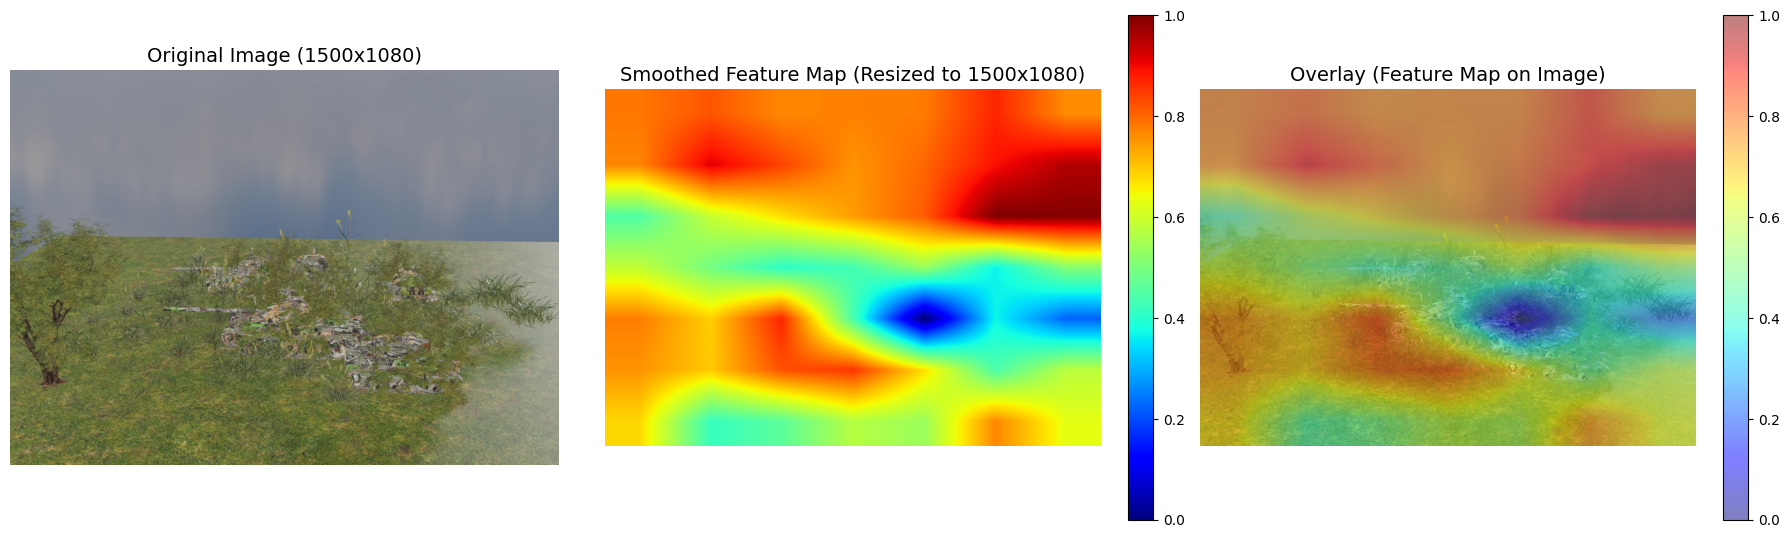

Image path: dasatet/Military-Camouflage-MHCD2022/camouflage/images/0_grass-1.jpg
Original image shape: (1080, 1500, 3)
Smoothed resized shape: torch.Size([1, 64, 1080, 1500])
Feature map value range: [-0.2661, 0.0392]
tensor([[ 0.0298, -0.1313,  0.0451,  0.0198]])
feat shape  torch.Size([1, 64, 224, 224])
Mask not found: dasatet/COD10k-v2/Test/GT_Objects/GT_Object/0_snow-16.png


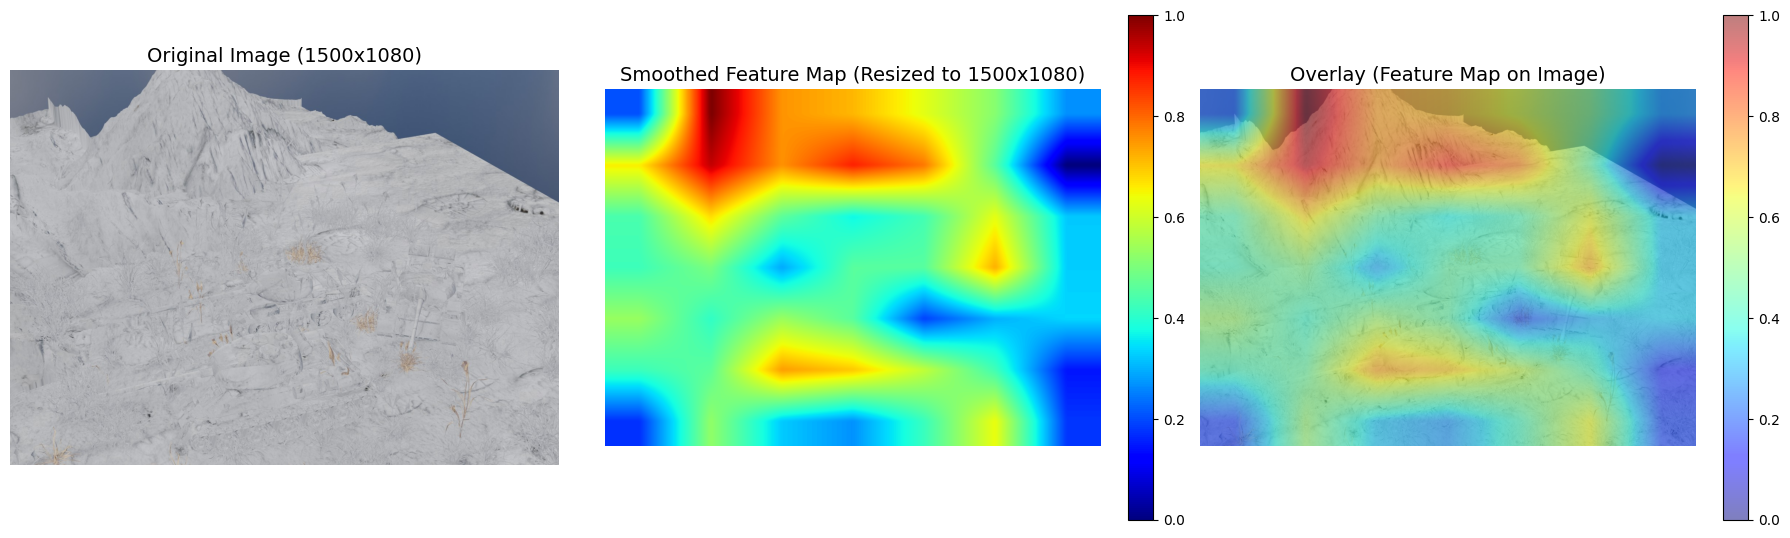

Image path: dasatet/Military-Camouflage-MHCD2022/camouflage/images/0_snow-16.jpg
Original image shape: (1080, 1500, 3)
Smoothed resized shape: torch.Size([1, 64, 1080, 1500])
Feature map value range: [-0.1238, 0.1811]
tensor([[ 0.0719, -0.1359, -0.0011,  0.1132]])
feat shape  torch.Size([1, 64, 224, 224])
Mask not found: dasatet/COD10k-v2/Test/GT_Objects/GT_Object/0_desert-19.png


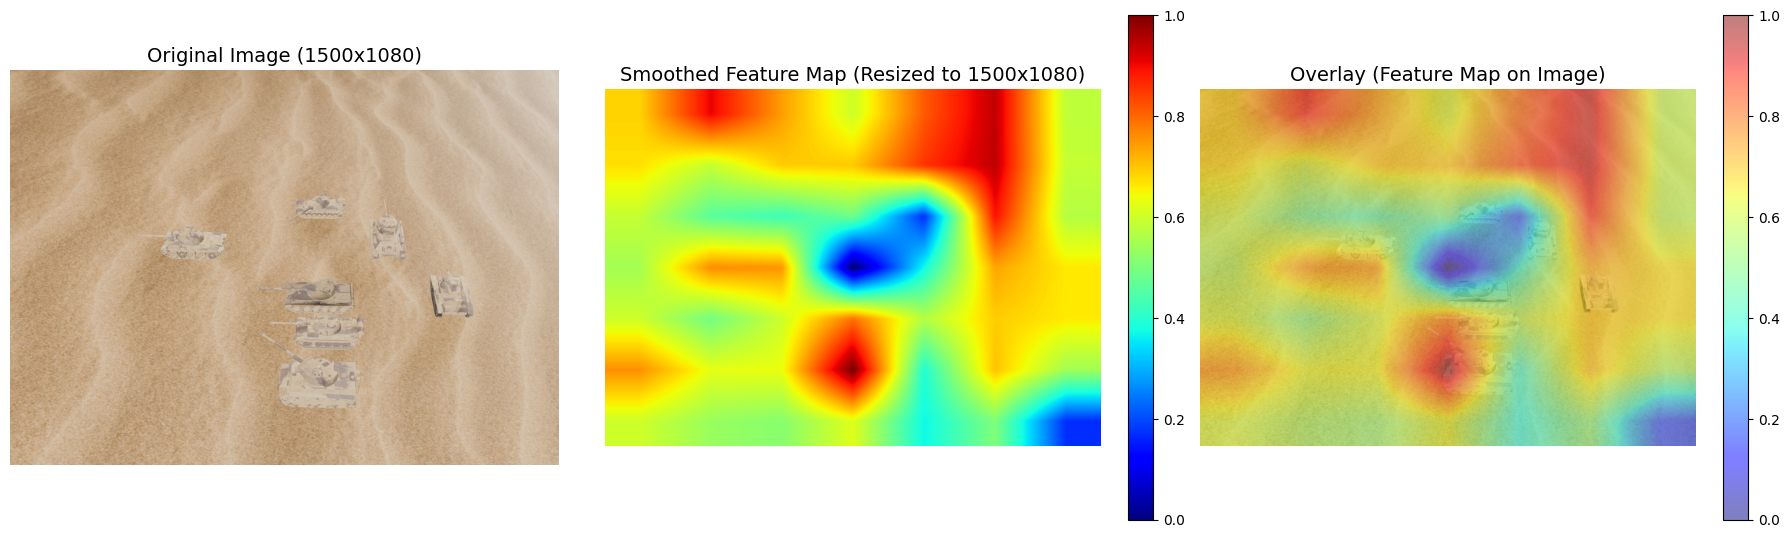

Image path: dasatet/Military-Camouflage-MHCD2022/camouflage/images/0_desert-19.jpg
Original image shape: (1080, 1500, 3)
Smoothed resized shape: torch.Size([1, 64, 1080, 1500])
Feature map value range: [-0.2291, 0.0951]
tensor([[ 0.0838, -0.1083,  0.0086,  0.0072]])
feat shape  torch.Size([1, 64, 224, 224])
Mask not found: dasatet/COD10k-v2/Test/GT_Objects/GT_Object/0_grass-6.png


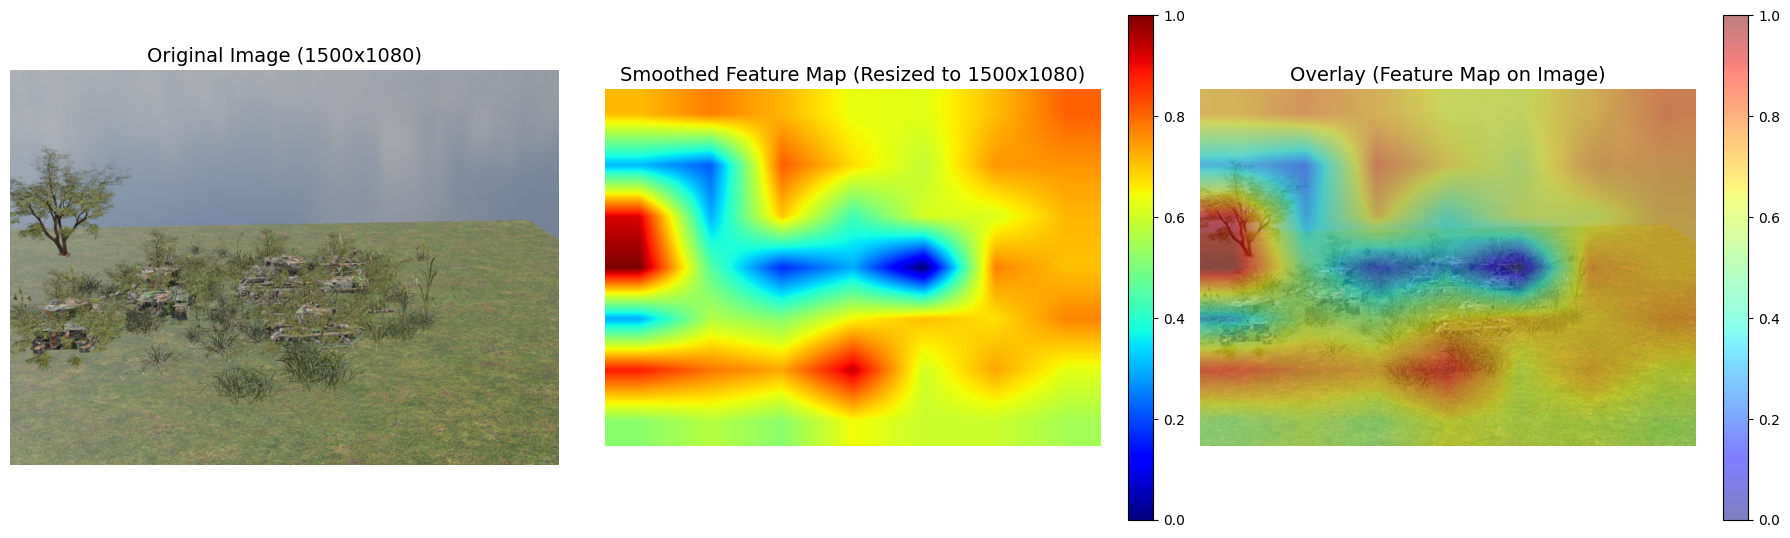

Image path: dasatet/Military-Camouflage-MHCD2022/camouflage/images/0_grass-6.jpg
Original image shape: (1080, 1500, 3)
Smoothed resized shape: torch.Size([1, 64, 1080, 1500])
Feature map value range: [-0.2509, 0.0629]
tensor([[ 0.0789, -0.0612,  0.0108,  0.0189]])
feat shape  torch.Size([1, 64, 224, 224])
Mask not found: dasatet/COD10k-v2/Test/GT_Objects/GT_Object/0_grass-3.png


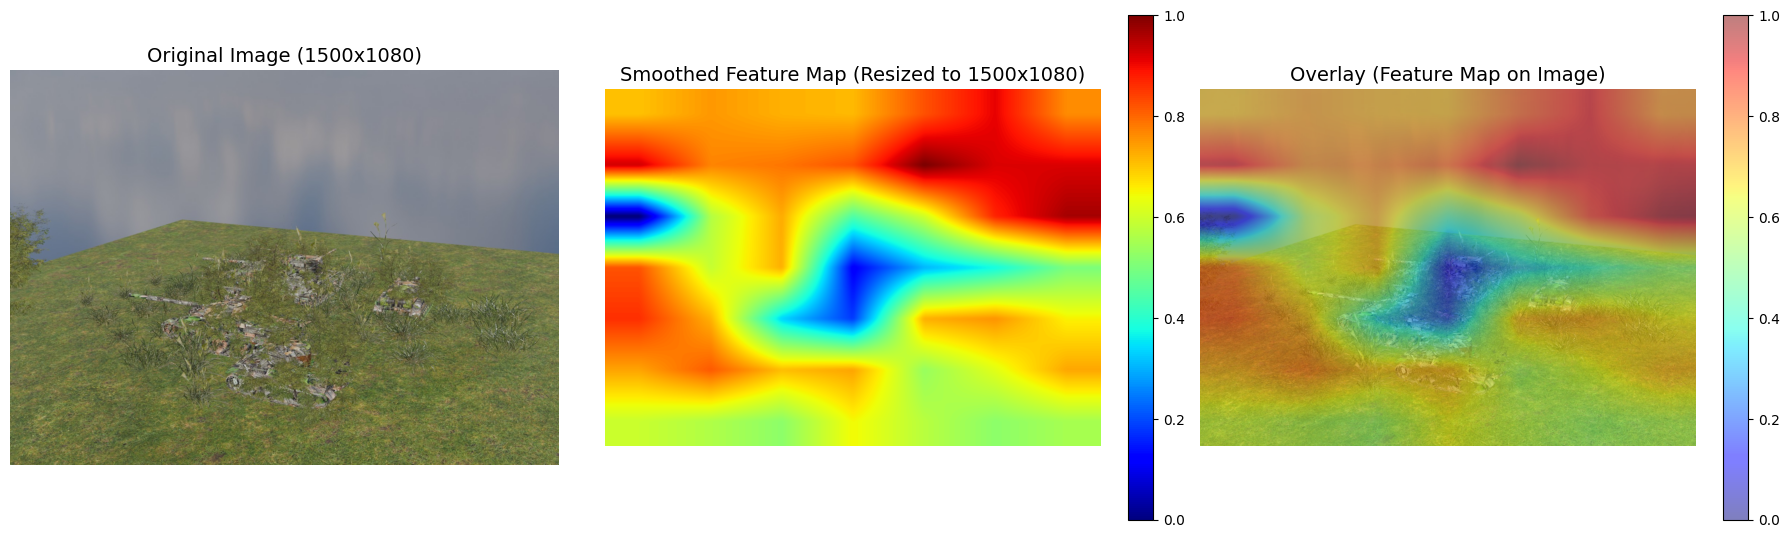

Image path: dasatet/Military-Camouflage-MHCD2022/camouflage/images/0_grass-3.jpg
Original image shape: (1080, 1500, 3)
Smoothed resized shape: torch.Size([1, 64, 1080, 1500])
Feature map value range: [-0.2280, 0.0157]
tensor([[ 0.0359, -0.1460,  0.0172,  0.0638]])
feat shape  torch.Size([1, 64, 224, 224])
Mask not found: dasatet/COD10k-v2/Test/GT_Objects/GT_Object/0_snow-10.png


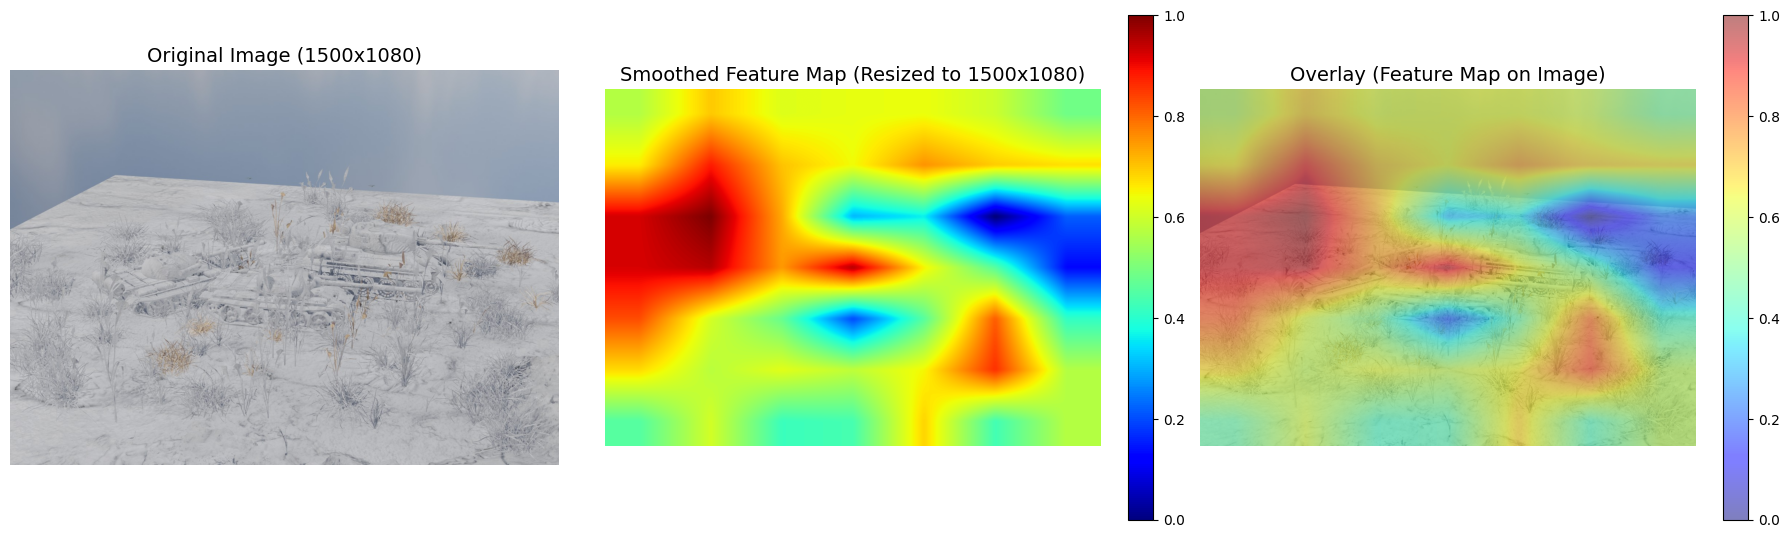

Image path: dasatet/Military-Camouflage-MHCD2022/camouflage/images/0_snow-10.jpg
Original image shape: (1080, 1500, 3)
Smoothed resized shape: torch.Size([1, 64, 1080, 1500])
Feature map value range: [-0.1949, 0.1107]
tensor([[ 0.0871, -0.0812,  0.0187,  0.0220]])
feat shape  torch.Size([1, 64, 224, 224])
Mask not found: dasatet/COD10k-v2/Test/GT_Objects/GT_Object/0_snow-18.png


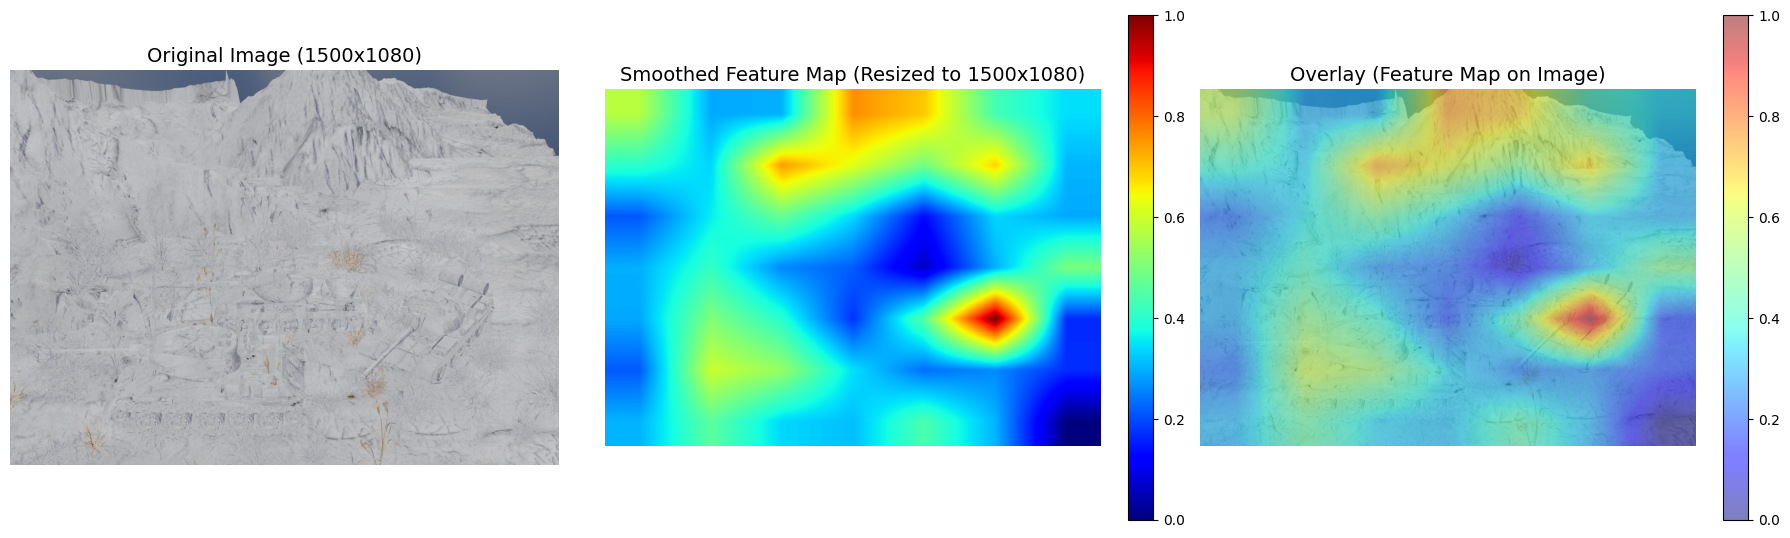

Image path: dasatet/Military-Camouflage-MHCD2022/camouflage/images/0_snow-18.jpg
Original image shape: (1080, 1500, 3)
Smoothed resized shape: torch.Size([1, 64, 1080, 1500])
Feature map value range: [-0.0974, 0.2398]
tensor([[ 0.0414, -0.1249,  0.0222,  0.0289]])
feat shape  torch.Size([1, 64, 224, 224])
Mask not found: dasatet/COD10k-v2/Test/GT_Objects/GT_Object/0_grass-13.png


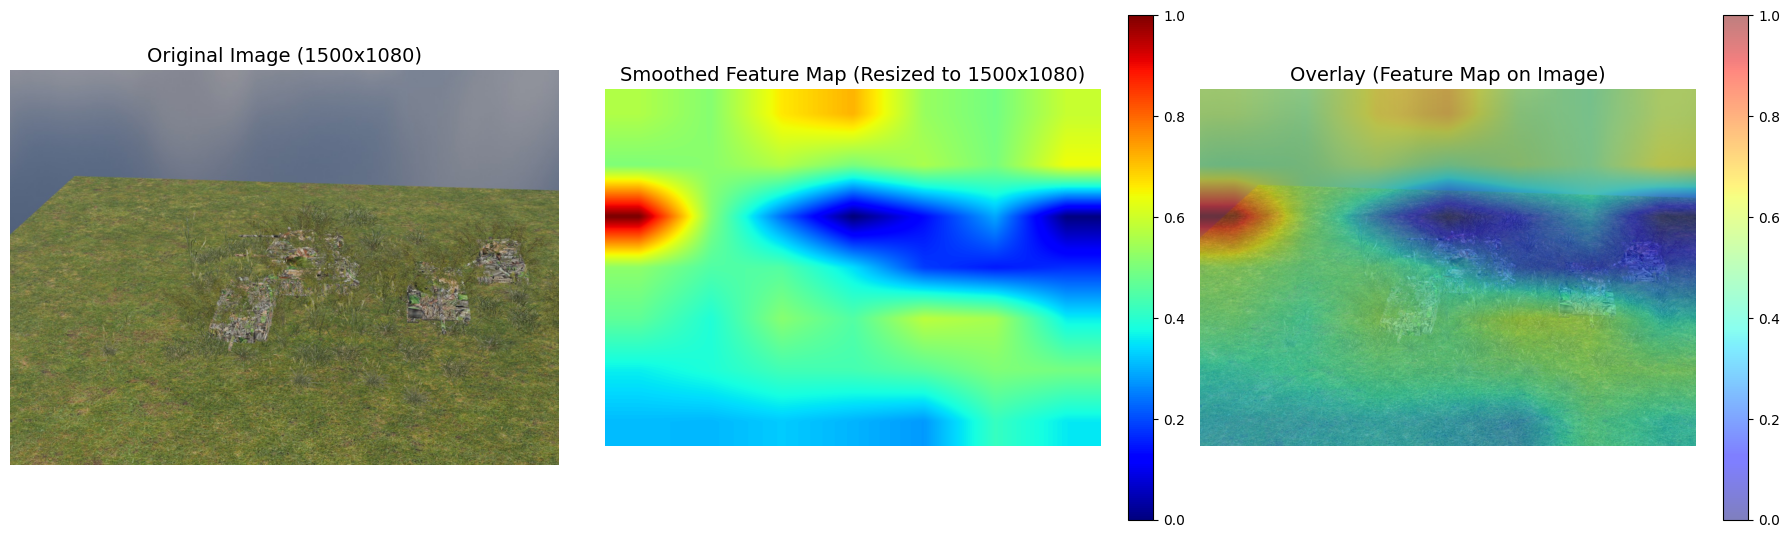

Image path: dasatet/Military-Camouflage-MHCD2022/camouflage/images/0_grass-13.jpg
Original image shape: (1080, 1500, 3)
Smoothed resized shape: torch.Size([1, 64, 1080, 1500])
Feature map value range: [-0.1814, 0.0945]
tensor([[ 0.0805, -0.0525,  0.0390,  0.0209]])
feat shape  torch.Size([1, 64, 224, 224])
Mask not found: dasatet/COD10k-v2/Test/GT_Objects/GT_Object/0_grass-7.png


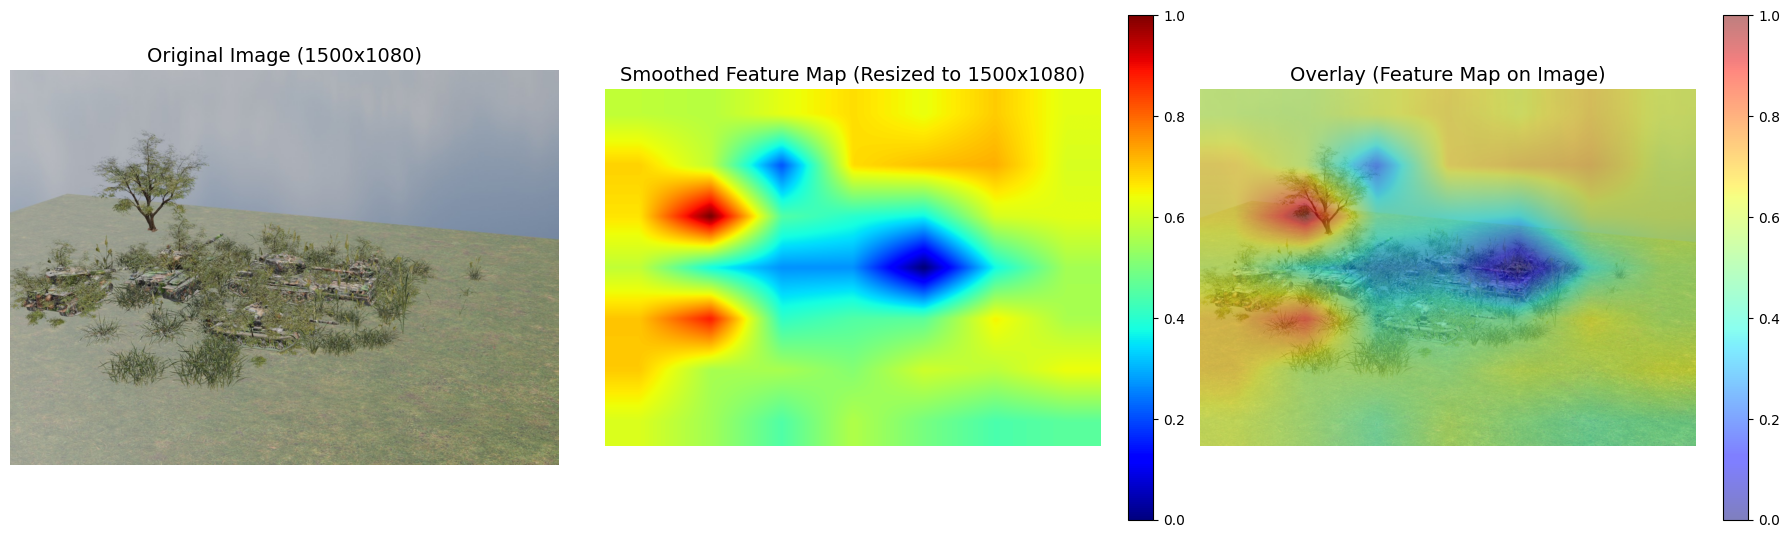

Image path: dasatet/Military-Camouflage-MHCD2022/camouflage/images/0_grass-7.jpg
Original image shape: (1080, 1500, 3)
Smoothed resized shape: torch.Size([1, 64, 1080, 1500])
Feature map value range: [-0.2685, 0.1336]
tensor([[ 0.0674, -0.0730,  0.0148,  0.0134]])
feat shape  torch.Size([1, 64, 224, 224])
Mask not found: dasatet/COD10k-v2/Test/GT_Objects/GT_Object/0_grass-5.png


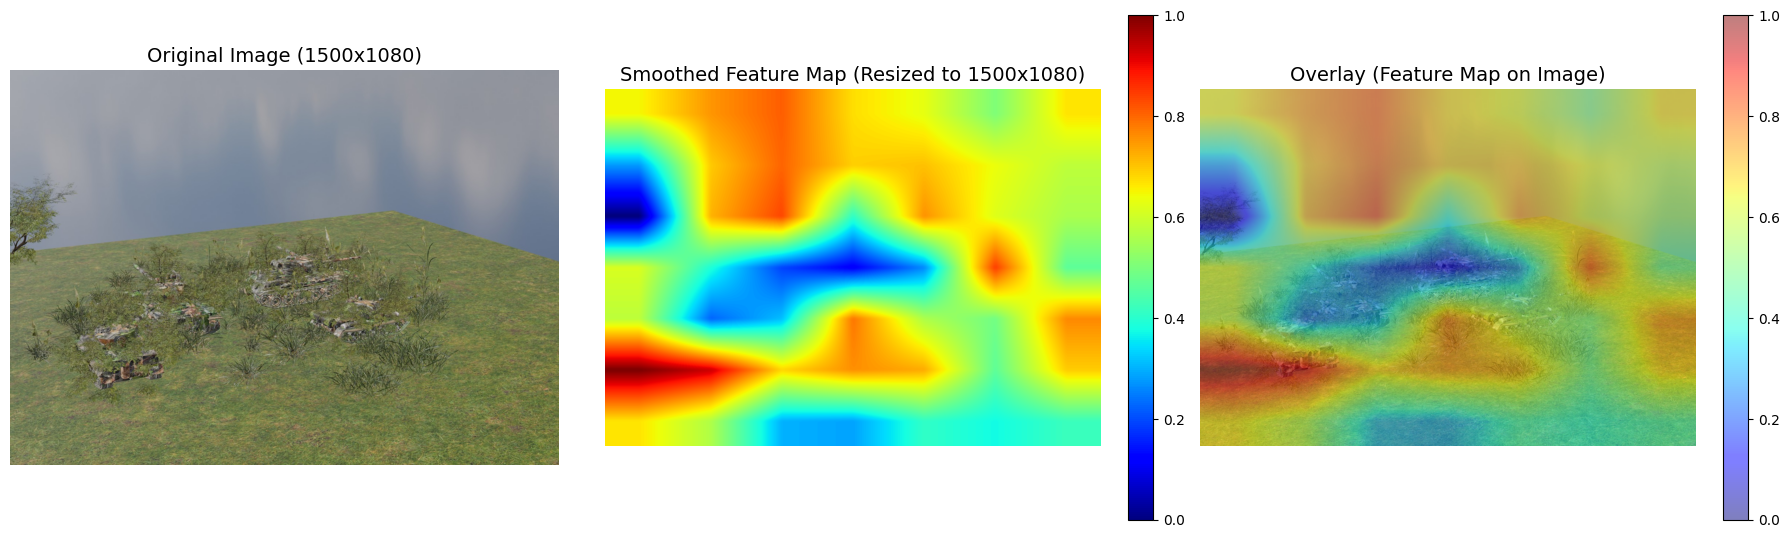

Image path: dasatet/Military-Camouflage-MHCD2022/camouflage/images/0_grass-5.jpg
Original image shape: (1080, 1500, 3)
Smoothed resized shape: torch.Size([1, 64, 1080, 1500])
Feature map value range: [-0.1756, 0.0265]


In [5]:
import torch
import torch.nn.functional as F
from torchvision.transforms import GaussianBlur
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import os
import random


folder_path = "dasatet/Military-Camouflage-MHCD2022/camouflage/images"

# Get all PNG files
png_files = [f for f in os.listdir(folder_path) 
             if f.lower().endswith(".jpg")] # and f.startswith("COD10K-CAM")]


# Pick 10 random files (or fewer if less than 10 exist)
selected_files = random.sample(png_files, min(10, len(png_files)))

for filename in selected_files:
    full_path = os.path.join(folder_path, filename)
    # print(f"Processing PNG file: {full_path}")
    test = dataloader.load_image(full_path, target_size=(224, 224))
    infer(test, full_path, mask_folder_path= "dasatet/COD10k-v2/Test/GT_Objects/GT_Object")